# 치매 환자의 뇌인지 일반인의 뇌인지 예측하기

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# 학습셋의 변형을 설정하는 부분입니다.- 이미지 생성 옵션
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )

# 실제 데이터가 있는 곳을 알려주고 이미지를 불러옴
train_generator = train_datagen.flow_from_directory(
       './image_data/train',   # 학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 160 images belonging to 2 classes.


In [5]:
# 테스트셋은 이미지 부풀리기 과정을 진행하지 않습니다.
test_datagen = ImageDataGenerator(rescale=1./255) # 정규화만 수행

test_generator = test_datagen.flow_from_directory(
       './image_data/test',      # 테스트셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),  # 이미지 크기
       batch_size=5,
       class_mode='binary')     # 치매 / 정상 이진 분류 이기 때문에 바이너리 모드로 실행

Found 120 images belonging to 2 classes.


In [6]:
# CNN 모델을 만들어 적용
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                   

In [7]:
# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다
history = model.fit(
       train_generator,                       # 앞에서 만든 train_generator를 학습 모델로 사용
       epochs=100,                            # 이미지 생성기에서 몇 개의 샘플을 뽑을지를 결정
       validation_data=test_generator,        # 검증셋
       validation_steps=10,
       callbacks=[early_stopping_callback])

Epoch 1/100
32/32 [==============================] - 2s 46ms/step - loss: 0.6971 - accuracy: 0.4938 - val_loss: 0.6843 - val_accuracy: 0.5400
Epoch 2/100
32/32 [==============================] - 1s 41ms/step - loss: 0.6940 - accuracy: 0.5250 - val_loss: 0.6923 - val_accuracy: 0.4800
Epoch 3/100
32/32 [==============================] - 1s 42ms/step - loss: 0.6835 - accuracy: 0.5437 - val_loss: 0.6944 - val_accuracy: 0.4400
Epoch 4/100
32/32 [==============================] - 1s 43ms/step - loss: 0.6787 - accuracy: 0.5562 - val_loss: 0.6670 - val_accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 1s 42ms/step - loss: 0.6564 - accuracy: 0.6500 - val_loss: 0.6463 - val_accuracy: 0.7000
Epoch 6/100
32/32 [==============================] - 1s 40ms/step - loss: 0.6198 - accuracy: 0.6812 - val_loss: 0.6193 - val_accuracy: 0.5800
Epoch 7/100
32/32 [==============================] - 1s 43ms/step - loss: 0.6243 - accuracy: 0.6812 - val_loss: 0.5907 - val_accuracy: 0.6200
Epoch 

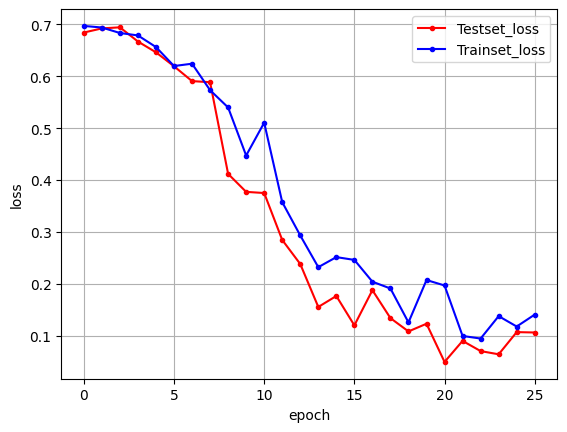

In [8]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()